In [703]:
import pandas as pd
import numpy as np
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
pandas2ri.activate()
import seaborn as sns
import matplotlib.pyplot as plt
import math

# EDA avant division : Pour comprendre et préparer les données.
# ACP après division : Pour éviter une fuite de données.

# 1. Chargement des données


In [704]:
TRAIN_PATH = "./data/spam_data_train.rda"
TEST_PATH = "./data/spam_data_test.rda"

ro.r["load"](TRAIN_PATH)
ro.r["load"](TEST_PATH)

train_data = ro.r["data_train"]
test_data = ro.r["data_test"]

train_df = pandas2ri.rpy2py(train_data)
test_df = pandas2ri.rpy2py(test_data)

In [705]:
print(train_data.head())
# Exemple d'analyse : description statistique
print(train_df.describe())
# liste des colunnes
print(train_df.columns)
#nmbr de lignes et de colonnes
print(train_df.shape)

     word_freq_make word_freq_address word_freq_all word_freq_3d word_freq_our
455             0.0               0.0          0.89            0          1.79
2246            0.0               0.0          0.00            0          0.00
1935            0.0               0.0          0.00            0          0.00
1384            0.0               0.0          0.00            0          1.82
679             0.1               0.1          0.70            0          0.60
4129            0.0               0.0          0.00            0          0.00
     word_freq_over word_freq_remove word_freq_internet word_freq_order
455            0.44             0.00               0.00            0.00
2246           0.00             0.00               0.00            0.00
1935           0.00             0.00               0.00            0.00
1384           0.36             0.36               0.72            0.36
679            0.20             0.40               0.10            1.41
4129           

In [706]:
print(test_df.head())
# Exemple d'analyse : description statistique
print(test_df.describe())
# liste des colunnes
print(test_df.columns)
#nmbr de lignes et de colonnes
print(test_df.shape)

      word_freq_make  word_freq_address  word_freq_all  word_freq_3d  \
2961            0.00                0.0           0.00          0.00   
2515            0.00                0.0           0.00          0.00   
3246            0.00                0.0           0.00          0.00   
1117            0.58                0.0           0.00         35.46   
2340            0.69                0.0           0.69          0.00   

      word_freq_our  word_freq_over  word_freq_remove  word_freq_internet  \
2961           0.00             0.0              0.00                0.00   
2515           0.00             0.0              0.00                0.00   
3246           0.00             0.0              0.00                0.00   
1117           0.58             0.0              0.58                0.58   
2340           0.00             0.0              0.00                0.00   

      word_freq_order  word_freq_mail  ...  word_freq_conference  char_freq_;  \
2961              0.0  

In [707]:
# Calculer le nombre de valeurs manquantes par colonne
sun_null_train_df = train_df.isnull().sum()

# Vérifier s'il y a des colonnes avec des données manquantes
if (sun_null_train_df > 0).any():
    # Afficher les colonnes avec des valeurs manquantes
    print("Les colonnes suivantes ont des données manquantes :")
    print(sun_null_train_df[sun_null_train_df > 0])
else:
    print("Aucune donnée manquante trouvée dans le dataset d'entraînement.")

Aucune donnée manquante trouvée dans le dataset d'entraînement.


In [708]:
#nmbr de lignes et de colonnes
print(train_df.shape)
# liste des colunnes
print(train_df.columns)

# Exemple d'analyse : description statistique
print(train_df.describe())

(2588, 58)
Index(['word_freq_make', 'word_freq_address', 'word_freq_all', 'word_freq_3d',
       'word_freq_our', 'word_freq_over', 'word_freq_remove',
       'word_freq_internet', 'word_freq_order', 'word_freq_mail',
       'word_freq_receive', 'word_freq_will', 'word_freq_people',
       'word_freq_report', 'word_freq_addresses', 'word_freq_free',
       'word_freq_business', 'word_freq_email', 'word_freq_you',
       'word_freq_credit', 'word_freq_your', 'word_freq_font', 'word_freq_000',
       'word_freq_money', 'word_freq_hp', 'word_freq_hpl', 'word_freq_george',
       'word_freq_650', 'word_freq_lab', 'word_freq_labs', 'word_freq_telnet',
       'word_freq_857', 'word_freq_data', 'word_freq_415', 'word_freq_85',
       'word_freq_technology', 'word_freq_1999', 'word_freq_parts',
       'word_freq_pm', 'word_freq_direct', 'word_freq_cs', 'word_freq_meeting',
       'word_freq_original', 'word_freq_project', 'word_freq_re',
       'word_freq_edu', 'word_freq_table', 'word_freq_co

## --------------- Analyse des resultats -------------------
### 1. Count :
- Toutes les colonnes ont 2588 valeurs, ce qui signifie qu'il n'y a pas de données manquantes dans les variables analysées. Cela confirme une qualité correcte des données en termes de complétude.

###     2. Mean (moyenne) :
- Les valeurs moyennes des variables comme word_freq_* et char_freq_* sont faibles (typiquement inférieures à 0.3), ce qui indique que les mots ou caractères spécifiques ne représentent qu’une petite proportion dans la majorité des emails.
- Pour les variables liées à la capitalisation (capital_run_length_*), les moyennes montrent que les lettres majuscules ne sont pas très fréquentes en moyenne, avec une moyenne de 52.17 pour la somme totale (capital_run_length_total).

### 3. Standard Deviation (std) :
- Les écarts-types montrent une grande variabilité dans certaines colonnes. Par exemple :
char_freq_* a un écart-type élevé (1.268), indiquant que certains emails contiennent beaucoup de ces caractères spéciaux.
- capital_run_length_total a une variabilité extrême (283.29), ce qui pourrait être influencé par des emails contenant beaucoup de majuscules (souvent caractéristique de spams).

### 4. Min (minimum) :
- Toutes les variables commencent à 0, ce qui est logique : un email peut ne pas contenir un mot spécifique ou des lettres majuscules.

### 5. 25% et 50% (quartiles) :
- Le premier quartile (25%) et la médiane (50%) sont souvent à 0 pour les fréquences (word_freq_*, char_freq_*), indiquant qu’au moins 50% des emails ont très peu ou pas de fréquence de mots/lettres majuscules spécifiques.

### 6. 75% (troisième quartile) :
- La plupart des colonnes restent faibles au troisième quartile, sauf pour certaines comme capital_run_length_total (264), montrant que seulement 25% des emails ont un total de majuscules supérieur à cette valeur. Cela renforce la distinction potentielle entre spam et ham.

### 7. Max (maximum) :
- Les valeurs maximales pour certaines colonnes, comme capital_run_length_total (15,841), révèlent des outliers significatifs. Cela peut correspondre à des spams contenant une grande quantité de majuscules ou des anomalies dans les données.

In [709]:
# 1. Analyser la structure des données
print("=== Informations sur le dataset ===")
print(train_df.info())

=== Informations sur le dataset ===
<class 'pandas.core.frame.DataFrame'>
Index: 2588 entries, 455 to 365
Data columns (total 58 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   word_freq_make              2588 non-null   float64
 1   word_freq_address           2588 non-null   float64
 2   word_freq_all               2588 non-null   float64
 3   word_freq_3d                2588 non-null   float64
 4   word_freq_our               2588 non-null   float64
 5   word_freq_over              2588 non-null   float64
 6   word_freq_remove            2588 non-null   float64
 7   word_freq_internet          2588 non-null   float64
 8   word_freq_order             2588 non-null   float64
 9   word_freq_mail              2588 non-null   float64
 10  word_freq_receive           2588 non-null   float64
 11  word_freq_will              2588 non-null   float64
 12  word_freq_people            2588 non-null   float64
 13  w

In [710]:
# 2. Distribution des classes (spam vs ham)
print("\n=== Distribution des classes (label) ===")
print(train_df['label'].value_counts())  # Comptage des classes 0 (ham) et 1 (spam)
print(train_df['label'].value_counts(normalize=True) * 100)  # Pourcentage des classes


=== Distribution des classes (label) ===
label
0    1588
1    1000
Name: count, dtype: int64
label
0    61.360124
1    38.639876
Name: proportion, dtype: float64


# 2. Analyse exploratoire des données (EDA)

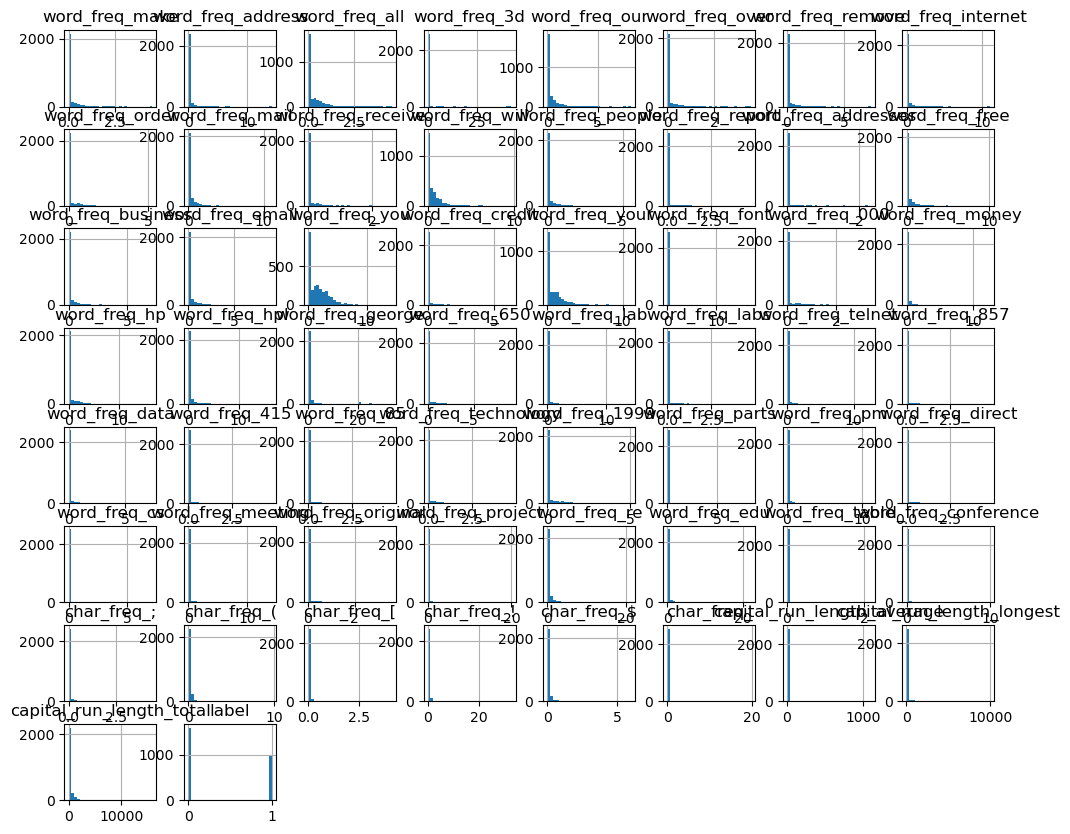

In [711]:
import matplotlib.pyplot as plt
train_df.hist(figsize=(12, 10), bins=30)
plt.show()


<AxesSubplot:>

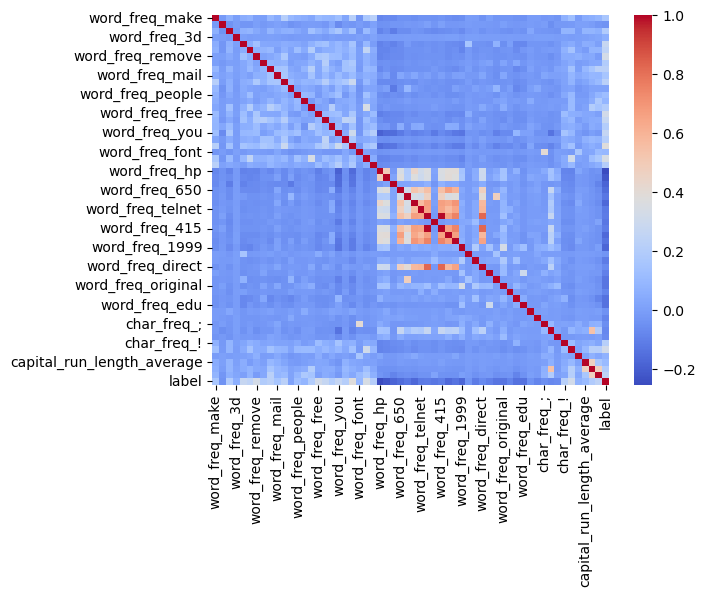

In [712]:
# Matrice de corrélation 
import seaborn as sns
corr_matrix = train_df.corr()
sns.heatmap(corr_matrix, cmap='coolwarm')


In [713]:
# Relation avec la cible 
correlations_with_target = train_df.corr()['label'].sort_values(ascending=False)
print(correlations_with_target)

label                         1.000000
word_freq_your                0.382897
word_freq_000                 0.340722
word_freq_remove              0.326225
word_freq_free                0.318739
char_freq_$                   0.318005
word_freq_our                 0.272558
word_freq_business            0.266480
word_freq_you                 0.262800
word_freq_over                0.243115
capital_run_length_total      0.240471
word_freq_receive             0.223663
word_freq_order               0.222946
char_freq_!                   0.212928
word_freq_credit              0.207933
word_freq_money               0.206663
word_freq_email               0.198466
word_freq_addresses           0.196146
word_freq_internet            0.193147
capital_run_length_longest    0.192041
word_freq_all                 0.189167
word_freq_make                0.160260
word_freq_mail                0.157411
word_freq_people              0.122571
capital_run_length_average    0.108684
word_freq_font           

In [714]:
# Conserver les features les plus corrélées avec la cible (label)
significant_features = correlations_with_target[abs(correlations_with_target) > 0.2].index
print("Features conservées :")
print(significant_features)
train_cor_df = train_df[significant_features]
train_cor_df.shape
significant_features_test = significant_features.drop('label', errors='ignore')

test = test_df[significant_features_test]

Features conservées :
Index(['label', 'word_freq_your', 'word_freq_000', 'word_freq_remove',
       'word_freq_free', 'char_freq_$', 'word_freq_our', 'word_freq_business',
       'word_freq_you', 'word_freq_over', 'capital_run_length_total',
       'word_freq_receive', 'word_freq_order', 'char_freq_!',
       'word_freq_credit', 'word_freq_money', 'word_freq_hpl', 'word_freq_hp'],
      dtype='object')


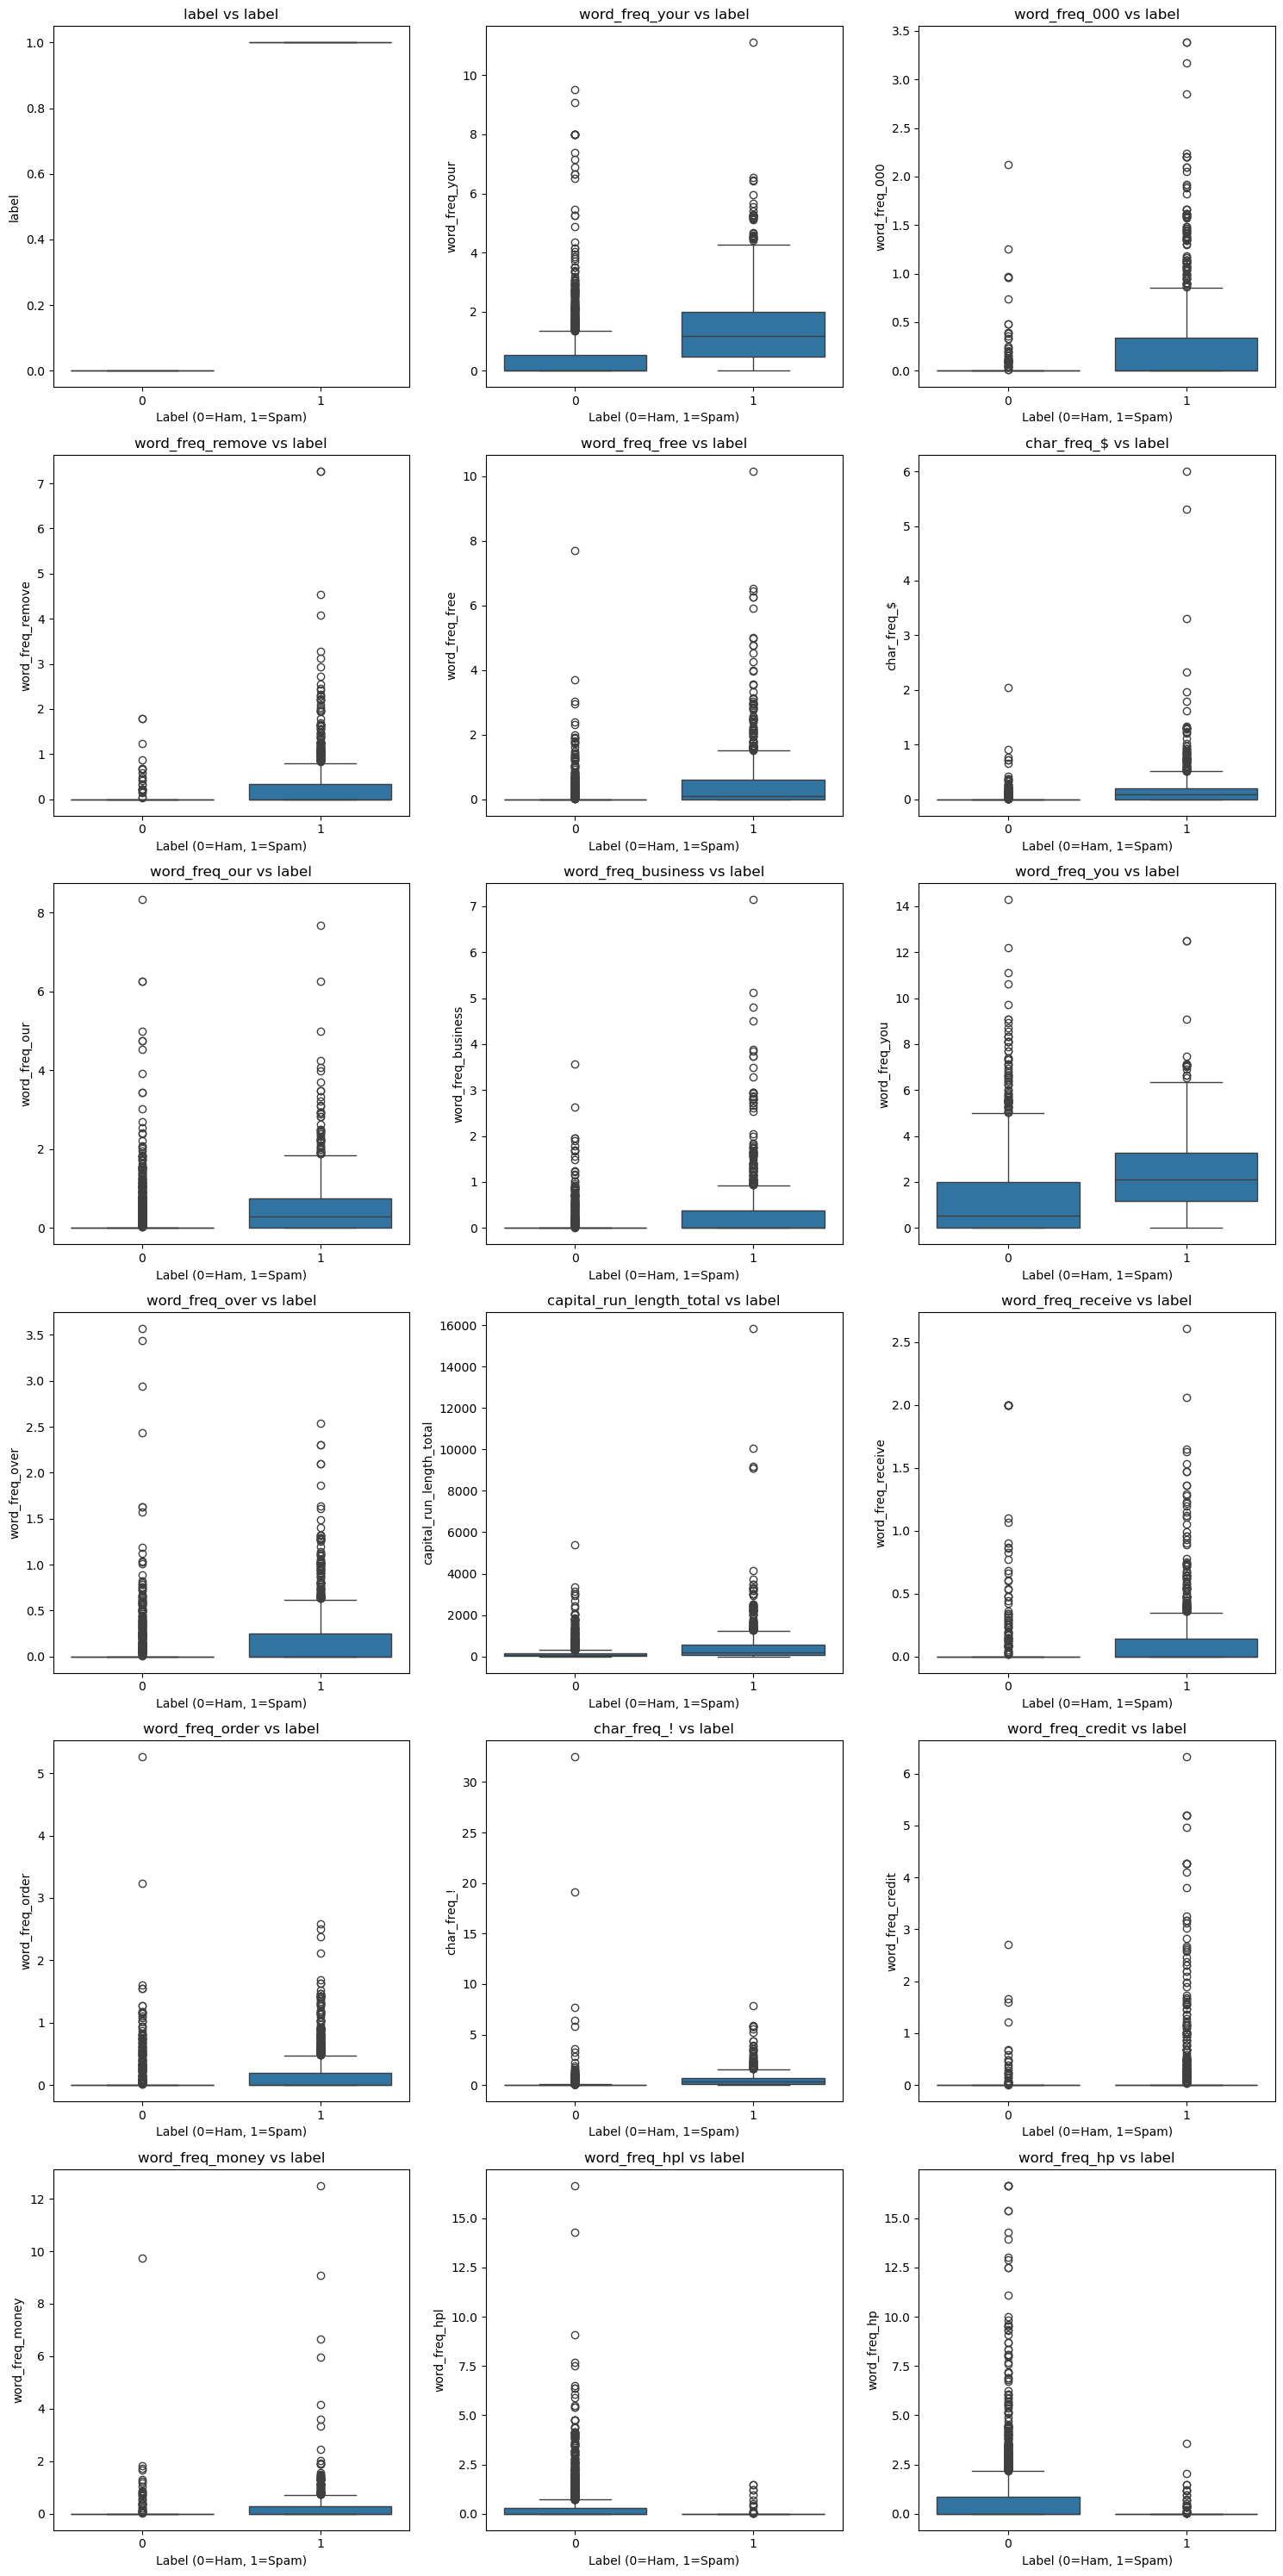

In [715]:
significant_features_label = significant_features.drop('label')
n_features = len(significant_features)
cols = 3  # Nombre de colonnes souhaitées
rows = math.ceil(n_features / cols)  # Calcul du nombre de lignes
fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 5))

# Étape 3 : Créer les boxplots
for i, feature in enumerate(significant_features):
    row, col = divmod(i, cols)
    sns.boxplot(x='label', y=feature, data=train_df, ax=axes[row, col])
    axes[row, col].set_title(f'{feature} vs label')
    axes[row, col].set_xlabel('Label (0=Ham, 1=Spam)')
    axes[row, col].set_ylabel(feature)

# Supprimer les axes inutilisés (s'il y a plus de sous-plots que de features)
for j in range(i + 1, rows * cols):
    fig.delaxes(axes.flatten()[j])

# Ajuster l'espacement entre les plots
plt.tight_layout()
plt.show()

In [716]:
from matplotlib import cm

# Fonction pour attribuer des couleurs en fonction de la classe des variables
def get_variable_class_color(feature_name):
    if feature_name.startswith("word_freq_"):
        return 'blue', 'word_freq'  # Classe "word"
    elif feature_name.startswith("char_freq_"):
        return 'green', 'char_freq'  # Classe "char"
    elif feature_name.startswith("capital_run_length_"):
        return 'red', 'capital_run_length'  # Classe "capital-run-length"
    else:
        return 'gray', 'other'  # Autres cas (si besoin)

# Étape 6 : Cercle des corrélations (projection des variables sur les 2 premières composantes principales)
def plot_correlation_circle(vects_sorted, feature_names):
    # On prend les deux premières composantes principales
    pc1 = vects_sorted[:, 0]
    pc2 = vects_sorted[:, 1]
    
    # Tracer le cercle des corrélations
    plt.figure(figsize=(8, 8))
    ax = plt.gca()

    # Tracer le cercle (x^2 + y^2 = 1)  
    circle = plt.Circle((0, 0), 1, color='gray', fill=False, linestyle='--')
    ax.add_artist(circle)

    # Liste pour la légende avec les variables et leur catégorie
    legend_labels = []

    # Ajouter les flèches pour chaque variable avec couleur en fonction de la classe
    for i, feature in enumerate(feature_names):
        color, category = get_variable_class_color(feature)  # Obtenir la couleur et la catégorie
        ax.quiver(0, 0, pc1[i], pc2[i], angles='xy', scale_units='xy', scale=1, 
                  color=color)
        
        # Déterminer si la variable est associée à PC1 ou PC2
        if abs(pc1[i]) > abs(pc2[i]):
            component = 'PC1'
        else:
            component = 'PC2'

        # Ajouter des labels aux flèches avec l'annotation (PC1) ou (PC2)
        ax.text(pc1[i] * 1.1, pc2[i] * 1.1, f'{feature} ({component})', color='black', ha='center', va='center', fontsize=10)

        # Ajouter l'entrée dans la légende avec PC1 ou PC2
        legend_labels.append(f'{feature} ({component})')

    # Configurer le graphique
    ax.set_xlim([-1.2, 1.2])
    ax.set_ylim([-1.2, 1.2])
    ax.set_aspect('equal')
    plt.axhline(0, color='black', linewidth=0.5)
    plt.axvline(0, color='black', linewidth=0.5)

    # Titres et légende
    plt.title('Cercle des Corrélations (2 premières composantes principales)', fontsize=14)
    plt.xlabel('Première composante principale', fontsize=12)
    plt.ylabel('Deuxième composante principale', fontsize=12)

    # Créer une légende personnalisée avec toutes les variables et leurs composantes associées
    handles = []
    for label in legend_labels:
        color = 'blue' if 'word_freq' in label else 'green' if 'char_freq' in label else 'red' if 'capital_run_length' in label else 'gray'
        handles.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=label))

    # Afficher la légende
    plt.legend(handles=handles, loc='best', fontsize=8)

    plt.grid(True)
    plt.show()

# Exemple d'utilisation (en supposant que 'vects_sorted' contient les vecteurs propres triés et 'feature_names' les noms des variables)
# plot_correlation_circle(vects_sorted, feature_names)


In [717]:
from sklearn.model_selection import train_test_split

# Séparer les caractéristiques et la cible si nécessaire
X = train_cor_df.drop('label', axis=1)  
y = train_cor_df['label']               

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [718]:
# Vérifier les dimensions
print("Train features shape:", X_train.shape)
print("Test features shape:", X_test.shape)
print("Train labels shape:", y_train.shape)
print("Test labels shape:", y_test.shape)

Train features shape: (2070, 17)
Test features shape: (518, 17)
Train labels shape: (2070,)
Test labels shape: (518,)


# 3. ACP

In [719]:
def plot_acp(X__train_reduced, vects_sorted, lambdas_sorted, feature_names, label_colors=None, labels=None):
        plt.figure(figsize=(12, 8))

        # Cercle des corrélations
        plt.axhline(0, color='grey', linestyle='--', linewidth=0.7)
        plt.axvline(0, color='grey', linestyle='--', linewidth=0.7)
        circle = plt.Circle((0, 0), 1, color='blue', fill=False, linestyle='--', linewidth=1.5)
        plt.gca().add_artist(circle)

        # Flèches des variables
        for i in range(vects_sorted.shape[1]):
            plt.arrow(0, 0, vects_sorted[0, i], vects_sorted[1, i],
                      color='r', alpha=0.8, head_width=0.03)
            plt.text(vects_sorted[0, i] * 1.1, vects_sorted[1, i] * 1.1,
                     feature_names[i], color='r', ha='center', va='center')

        # Points projetés
        if label_colors is None:
            label_colors = ['blue'] * X__train_reduced.shape[0]
        scatter = plt.scatter(X__train_reduced[:, 0], X__train_reduced[:, 1],
                              c=label_colors, alpha=0.6, cmap='viridis', edgecolor='k')
        if labels is not None:
            plt.legend(handles=scatter.legend_elements()[0], labels=np.unique(labels))

        # Configurations du graphique
        plt.title("Cercle des corrélations et projection des observations")
        plt.xlabel(f"Composante principale 1 ({lambdas_sorted[0] / sum(lambdas_sorted) * 100:.2f}%)")
        plt.ylabel(f"Composante principale 2 ({lambdas_sorted[1] / sum(lambdas_sorted) * 100:.2f}%)")
        plt.grid()
        plt.show()

In [720]:
from ACP import ACP

acp = ACP()

# Étape 1 : Centrage des données
X_train_standardized, mean, std = acp.standardize(X_train)

# Étape 2 : Matrice de covariance
cov_matrix = acp.scatter(X_train_standardized) 

# Étape 3 : Calcul des valeurs propres et vecteurs propres
lambdas, lambdas_sorted, vects, vects_sorted = acp.sort(cov_matrix)

# Étape 4 : Sélection du nombre de composantes principales
k, explained_variance, base = acp.fixe_k(lambdas, lambdas_sorted, vects_sorted)

print(f"Nombre de composantes principales retenues : {k}")
print(f"Variance expliquée cumulée : {explained_variance * 100:.2f}%")

# Étape 5 : Projection des données
# X__train_reduced = acp.proj(X_train_standardized, base)
X_train_reduced = np.dot(X_train_standardized, base.T)
X_train_reduced_df = pd.DataFrame(X_train_reduced, index=None)
print(f"Dimensions des données après projection : {X_train_reduced.shape}")

X_test_standardized = (X_test - mean) / std
X_test_reduced = np.dot(X_test_standardized, base.T)
X_test_reduced_df = pd.DataFrame(X_test_reduced, index=None)
print(f"Dimensions des données après projection : {X_test_reduced.shape}")

test_standardized = (test - mean) / std
test_reduced = np.dot(test_standardized, base.T)
test_reduced_df = pd.DataFrame(test_reduced, index=None)
print(f"Dimensions des données test après projection : {test_reduced.shape}")




Nombre de composantes principales retenues : 10
Variance expliquée cumulée : 72.58%
Dimensions des données après projection : (2070, 10)
Dimensions des données après projection : (518, 10)
Dimensions des données test après projection : (862, 10)


In [721]:
# Récupérer les noms des colonnes originales
original_feature_names = X_train.columns

# Identifier les features importantes pour chaque composante principale
selected_features = []
for i in range(base.shape[0]):  # Parcourir les composantes principales
    component = vects_sorted[:, i]  # Vecteur propre correspondant à la composante principale
    feature_indices = np.argsort(np.abs(component))[-5:][::-1]  # Indices des 5 plus grandes valeurs absolues
    feature_names = [original_feature_names[j] for j in feature_indices]
    selected_features.append((f"Composante principale {i+1}", feature_names))

# Afficher les features importantes
for component_name, features in selected_features:
    print(f"{component_name} : {features}")

Composante principale 1 : ['word_freq_your', 'word_freq_you', 'word_freq_business', 'word_freq_receive', 'word_freq_hp']
Composante principale 2 : ['capital_run_length_total', 'char_freq_$', 'word_freq_order', 'word_freq_000', 'word_freq_hp']
Composante principale 3 : ['word_freq_hp', 'word_freq_hpl', 'word_freq_business', 'word_freq_receive', 'word_freq_remove']
Composante principale 4 : ['word_freq_hpl', 'word_freq_money', 'word_freq_hp', 'char_freq_!', 'word_freq_you']
Composante principale 5 : ['word_freq_money', 'word_freq_our', 'word_freq_000', 'word_freq_remove', 'word_freq_order']
Composante principale 6 : ['word_freq_free', 'word_freq_over', 'char_freq_!', 'capital_run_length_total', 'word_freq_your']
Composante principale 7 : ['char_freq_!', 'word_freq_credit', 'word_freq_money', 'word_freq_over', 'word_freq_our']
Composante principale 8 : ['word_freq_our', 'word_freq_credit', 'word_freq_receive', 'word_freq_remove', 'word_freq_over']
Composante principale 9 : ['word_freq_ove

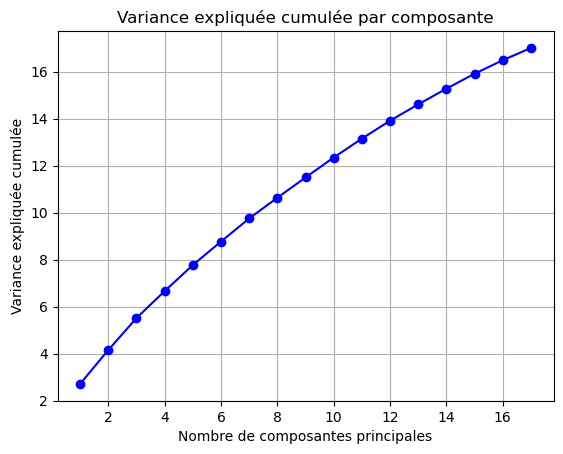

In [722]:
plt.plot(range(1, len(lambdas_sorted) + 1), np.cumsum(lambdas_sorted), marker='o', color='b')
plt.title('Variance expliquée cumulée par composante')
plt.xlabel('Nombre de composantes principales')
plt.ylabel('Variance expliquée cumulée')
plt.grid(True)
plt.show()


# 4. Entraînement des modèles

### 4.1 Régression logistique

In [723]:
from LogisticRegression import LogisticRegression
from sklearn.metrics import accuracy_score

# Instancier et entraîner le classificateur de régression logistique
lr_classifier = LogisticRegression()
lr_classifier.fit(X_train_reduced_df, y_train.values)



# Prédire les étiquettes sur l'ensemble de test
lr_predictions = lr_classifier.predict(X_test_reduced_df.values)

# Calculer l'exactitude
# lr_accuracy = lr_classifier.accuracy(y_test.values, lr_predictions)
lr_accuracy = np.sum(y_test.values == lr_predictions) / len(y_test.values)
print(f"L'exactitude du modèle est de {lr_accuracy * 100:.2f}%")

lr_accuracy_2 = accuracy_score(y_test.values, lr_predictions)
print(f"L'exactitude du modèle est de {lr_accuracy_2 * 100:.2f}%")

L'exactitude du modèle est de 86.29%
L'exactitude du modèle est de 86.29%


### 4.2 KNN

In [724]:
# from KNN import KNN
# from sklearn.metrics import accuracy_score

# # Instancier et entraîner le classificateur de régression logistique
# knn_classifier = KNN()
# #Faire une boucle pour trouver le meilleur k

# # 1. Définir une liste de valeurs de k
# k_values = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19]

# # 2. Initialiser une liste pour stocker les scores
# scores = []
# knn_predictions = []
# # 3. Entraîner le modèle pour chaque valeur de k
# database_train_df = pd.concat([X_train_reduced_df, y_train], axis=1)
# database_train = database_train_df.to_numpy()

    
# for k in k_values:
#     for u in X_test_reduced_df.values:    
#         result = knn_classifier.classify(u, database_train, k)
#         knn_predictions.append(result)
#     knn_accuracy = accuracy_score(y_train.values, knn_predictions)
#     scores.append(knn_accuracy)


# # # 4. Trouver la meilleure valeur de k
# best_k = k_values[np.argmax(scores)]
# print(f"Meilleure valeur de k : {best_k}")
# #l'accuracy du model avec le best k
# nb_accuracy = np.max(scores)
# # 5. Tracer la courbe de validation
# plt.figure(figsize=(10, 6))
# plt.plot(k_values, scores, marker='o', linestyle='-', color='b')
# plt.title("Validation Curve")
# plt.xlabel("k")
# plt.ylabel("Accuracy")
# plt.grid()
# plt.show()

# accuracy_best_k = k_values[np.argmax(scores)]
# # Calculer l'exactitude
# knn_accuracy_final = accuracy_score(y_train.values, knn_predictions)
# print(f"L'exactitude du modèle est de {nb_accuracy * 100:.2f}%")


Meilleure valeur de k : 5
L'exactitude du modèle est de 90.15%


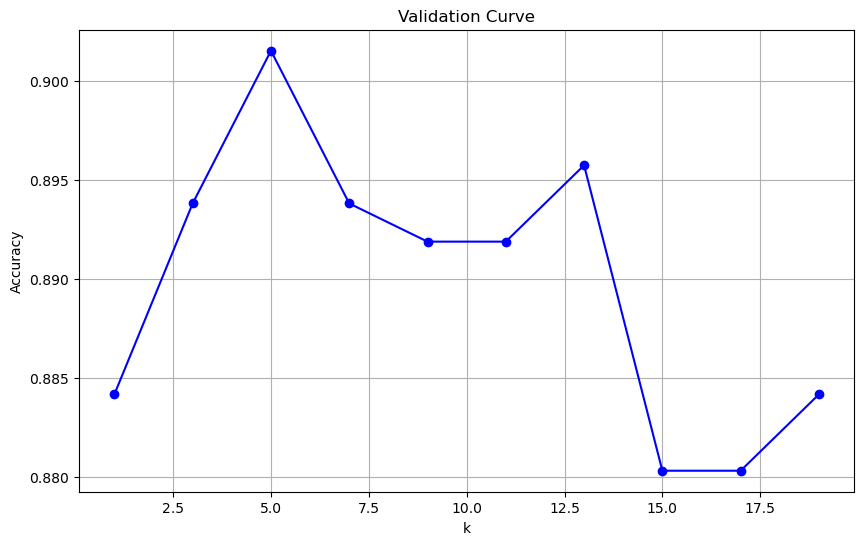

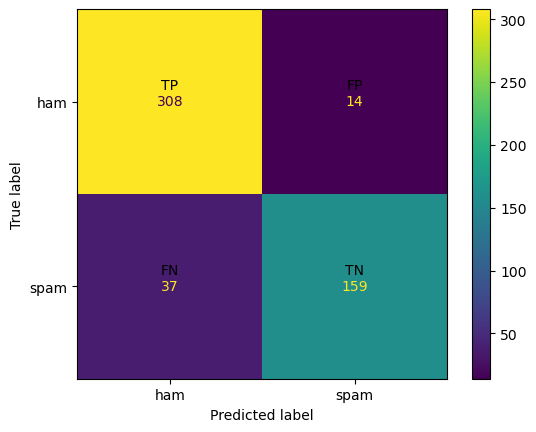

In [725]:
#faire une knn avec skytlearn et trouver le best_k
from sklearn.neighbors import KNeighborsClassifier

k_values = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19]

scores = []
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_reduced_df, y_train.values)
    y_pred = knn.predict(X_test_reduced_df)
    accuracy = accuracy_score(y_test.values, y_pred)
    scores.append(accuracy)

best_k = k_values[np.argmax(scores)]
print(f"Meilleure valeur de k : {best_k}")
#print accuracy du best_k
nb_accuracy = np.max(scores)
print(f"L'exactitude du modèle est de {nb_accuracy * 100:.2f}%")
# 5. Tracer la courbe de validation

knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X_train_reduced_df, y_train.values)
y_pred = knn.predict(X_test_reduced_df)
accuracy = accuracy_score(y_test.values, y_pred)


plt.figure(figsize=(10, 6))
plt.plot(k_values, scores, marker='o', linestyle='-', color='b')
plt.title("Validation Curve")
plt.xlabel("k")
plt.ylabel("Accuracy")
plt.grid()
plt.show()

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# Matrice de confusion
nb_cm = confusion_matrix(y_test, y_pred)

# Afficher la matrice de confusion
disp = ConfusionMatrixDisplay(confusion_matrix=nb_cm, display_labels=['ham', 'spam'])
disp.plot()

# Annoter les cases
for i in range(nb_cm.shape[0]):
    for j in range(nb_cm.shape[1]):
        # Ajouter les valeurs avec texte compact
        if i == j:
            label = "TP" if i == 0 else "TN"
        else:
            label = "FP" if i == 0 else "FN"
        plt.text(j, i, f"{label}\n\n", 
                 ha='center', va='center', color='black', fontsize=10)

plt.show()







### 4.3 Naive Bayes

In [726]:
from Naive_Bayes import NaiveBayes

# Instancier et entraîner le classificateur Naive Bayes
nb_classifier = NaiveBayes()
nb_classifier.fit(X_train_reduced, y_train.values)

# Prédire les étiquettes sur l'ensemble de test
nb_predictions = nb_classifier.predict(X_test_reduced)

# Calculer l'exactitude
nb_accuracy = nb_classifier.accuracy(y_test, nb_predictions)
print(f"L'exactitude du modèle est de {nb_accuracy * 100:.2f}%")

L'exactitude du modèle est de 62.16%


/home/user/Bureau/M2-CISD/Analyse_Data/Projet/Projet_Analyse/Naive_Bayes.py:51: RuntimeWarning: invalid value encountered in log
  scores[i, label] += np.log(self.phi_y[label][j])


L'exactitude du modèle est de 78.19%


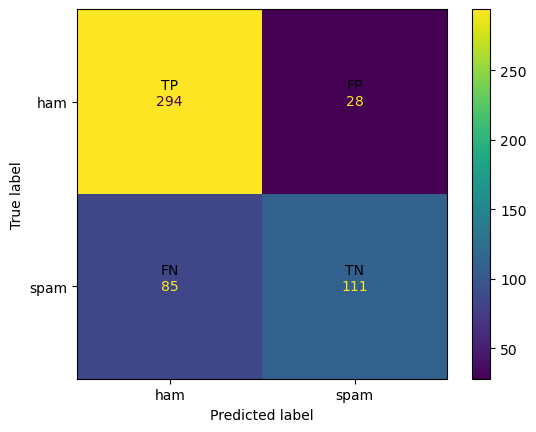

In [727]:
#faire une naive bayes avec skytlearn
from sklearn.naive_bayes import GaussianNB

# Instancier et entraîner le classificateur Naive Bayes
nb_classifier = GaussianNB()
nb_classifier.fit(X_train_reduced_df, y_train.values)

# Prédire les étiquettes sur l'ensemble de test
nb_predictions = nb_classifier.predict(X_test_reduced_df)

# Calculer l'exactitude
nb_accuracy = accuracy_score(y_test, nb_predictions)
print(f"L'exactitude du modèle est de {nb_accuracy * 100:.2f}%")

#faire un plot por voir les resultats de la naive bayes

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# Matrice de confusion
nb_cm = confusion_matrix(y_test, nb_predictions)

# Afficher la matrice de confusion
disp = ConfusionMatrixDisplay(confusion_matrix=nb_cm, display_labels=['ham', 'spam'])
disp.plot()

# Annoter les cases
for i in range(nb_cm.shape[0]):
    for j in range(nb_cm.shape[1]):
        # Ajouter les valeurs avec texte compact
        if i == j:
            label = "TP" if i == 0 else "TN"
        else:
            label = "FP" if i == 0 else "FN"
        plt.text(j, i, f"{label}\n\n", 
                 ha='center', va='center', color='black', fontsize=10)

plt.show()



L'exactitude du modèle est de 85.91%


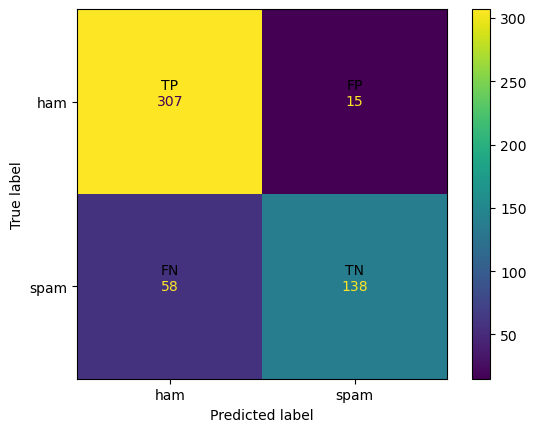

In [728]:
# faire une regression logistique avec skytlearn
from sklearn.linear_model import LogisticRegression

# Instancier et entraîner le classificateur de régression logistique
lr_classifier = LogisticRegression()
lr_classifier.fit(X_train_reduced_df, y_train.values)

# Prédire les étiquettes sur l'ensemble de test
lr_predictions = lr_classifier.predict(X_test_reduced_df)

# Calculer l'exactitude
lr_accuracy = accuracy_score(y_test, lr_predictions)
print(f"L'exactitude du modèle est de {lr_accuracy * 100:.2f}%")

# Matrice de confusion
nb_cm = confusion_matrix(y_test, lr_predictions)

# Afficher la matrice de confusion
disp = ConfusionMatrixDisplay(confusion_matrix=nb_cm, display_labels=['ham', 'spam'])
disp.plot()

# Annoter les cases
for i in range(nb_cm.shape[0]):
    for j in range(nb_cm.shape[1]):
        # Ajouter les valeurs avec texte compact
        if i == j:
            label = "TP" if i == 0 else "TN"
        else:
            label = "FP" if i == 0 else "FN"
        plt.text(j, i, f"{label}\n\n", 
                 ha='center', va='center', color='black', fontsize=10)

plt.show()


Accuracy: 0.94


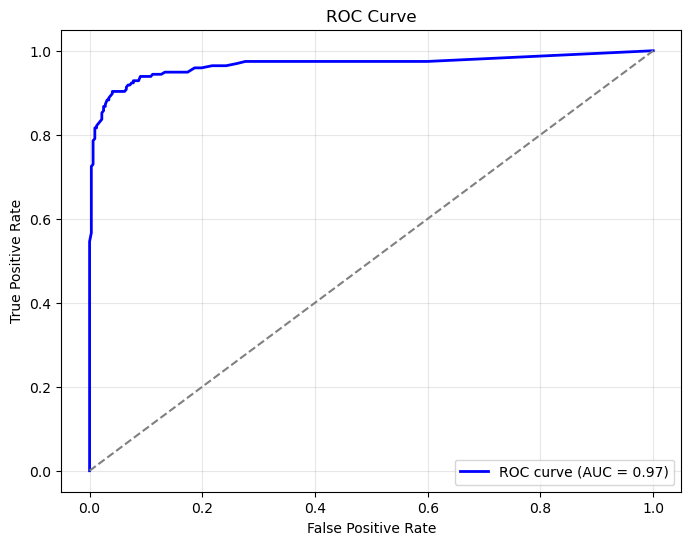

In [729]:
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

from sklearn.ensemble import RandomForestClassifier

# Créer et entraîner le modèle
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Prédire sur le jeu de test
y_pred = model.predict(X_test)

from sklearn.metrics import classification_report, accuracy_score

# Calculer l'exactitude
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Rapport de classification complet
#print(classification_report(y_test, y_pred))

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Probabilités pour la classe positive
y_proba = model.predict_proba(X_test)[:, 1]

# Calculer FPR, TPR et AUC
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

# Tracer la courbe ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

In [730]:
# def plot_roc(y_true, y_scores, title="ROC Curve"):
#     # Calculer TPR et FPR
#     fpr, tpr, _ = roc_curve(y_true, y_scores)
#     roc_auc = auc(fpr, tpr)

#     # Tracer la courbe ROC
#     plt.figure(figsize=(8, 6))
#     plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
#     plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonale aléatoire
#     plt.xlabel('False Positive Rate')
#     plt.ylabel('True Positive Rate')
#     plt.title(title)
#     plt.legend(loc='lower right')
#     plt.grid(alpha=0.3)
#     plt.show()

#     return roc_auc


In [731]:
def cross_validate_with_roc(model, X, y, k_folds=5):
    indices = np.arange(len(y))
    np.random.shuffle(indices)  # Mélange des données
    fold_size = len(y) // k_folds

    y_true = []  # Vrais labels consolidés
    y_scores = []  # Scores consolidés (probabilités ou scores de décision)

    for fold in range(k_folds):
        # Diviser les indices en train et test
        test_indices = indices[fold * fold_size:(fold + 1) * fold_size]
        train_indices = np.setdiff1d(indices, test_indices)

        # Utiliser .iloc pour accéder aux lignes par indices numériques
        X_train, y_train = X.iloc[train_indices], y.iloc[train_indices]
        X_test, y_test = X.iloc[test_indices], y.iloc[test_indices]

        # Entraîner le modèle
        model.fit(X_train, y_train)

        # Obtenir les scores prédits
        if hasattr(model, "predict_proba"):
            y_score = model.predict_proba(X_test)[:, 1]  # Probabilités pour la classe positive
        elif hasattr(model, "decision_function"):
            y_score = model.decision_function(X_test)  # Fonction de décision
        else:
            raise ValueError("Le modèle doit implémenter `predict_proba` ou `decision_function`.")

        y_true.extend(y_test)  # Ajouter les vrais labels
        y_scores.extend(y_score)  # Ajouter les scores

    return np.array(y_true), np.array(y_scores)


In [732]:
def plot_roc(y_true, y_scores, model_name):
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, lw=2, label=f'{model_name} (AUC = {roc_auc:.2f})')
    return roc_auc


(2070, 10)
(2070,)
(518, 10)
(518,)
(2588, 10)
(2588,)
--- KNN ---
AUC for KNN: 0.93
Accuracy for KNN: 0.93
--- Naive Bayes ---
AUC for Naive Bayes: 0.88
Accuracy for Naive Bayes: 0.78
--- Logistic Regression ---
AUC for Logistic Regression: 0.91
Accuracy for Logistic Regression: 0.87


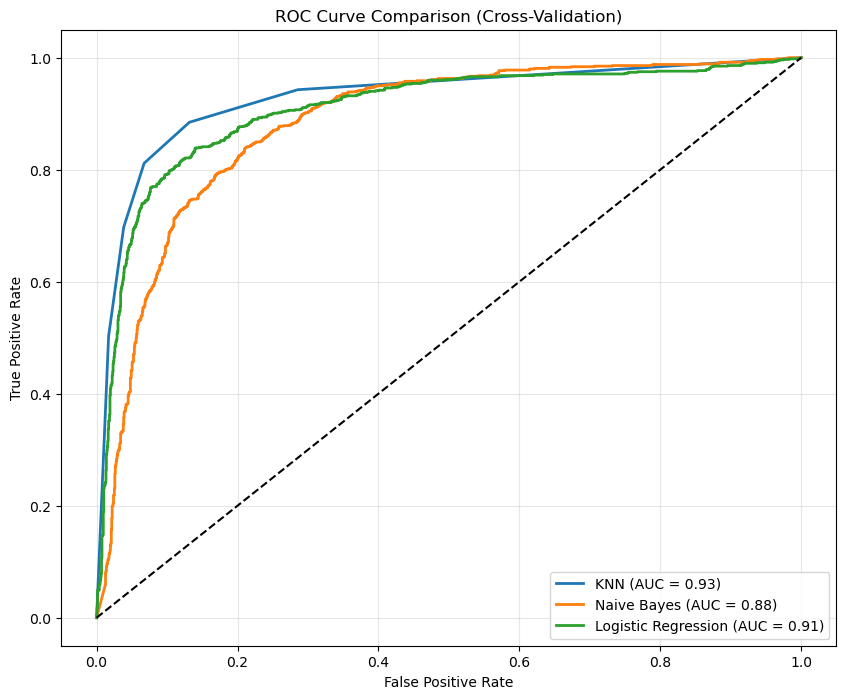

In [733]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

print(X_train_reduced_df.shape)
print(y_train.shape)
print(X_test_reduced_df.shape)
print(y_test.shape)

# Combiner les features X
X_combined = pd.concat([X_train_reduced_df, X_test_reduced_df], axis=0).reset_index(drop=True)

# Combiner les labels y
y_combined = pd.concat([pd.Series(y_train), pd.Series(y_test)], axis=0).reset_index(drop=True)

print(X_combined.shape)
print(y_combined.shape)

# Définir les modèles
models = {
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Naive Bayes": GaussianNB(),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42)
}

# Tracer les courbes ROC pour chaque modèle
plt.figure(figsize=(10, 8))
for model_name, model in models.items():
    print(f"--- {model_name} ---")

    # Effectuer la validation croisée avec collecte des scores
    y_true, y_scores = cross_validate_with_roc(model, X_combined, y_combined, k_folds=5)

    # Tracer la courbe ROC
    roc_auc = plot_roc(y_true, y_scores, model_name)
    print(f"AUC for {model_name}: {roc_auc:.2f}")
    #calcul de l'accuracy
    y_pred = model.predict(X_test_reduced_df)
    accuracy = accuracy_score(y_test, y_pred)
    
    print(f"Accuracy for {model_name}: {accuracy:.2f}")

# Finaliser le graphique ROC
plt.plot([0, 1], [0, 1], 'k--')  # Diagonale aléatoire
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison (Cross-Validation)')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()


(862,)


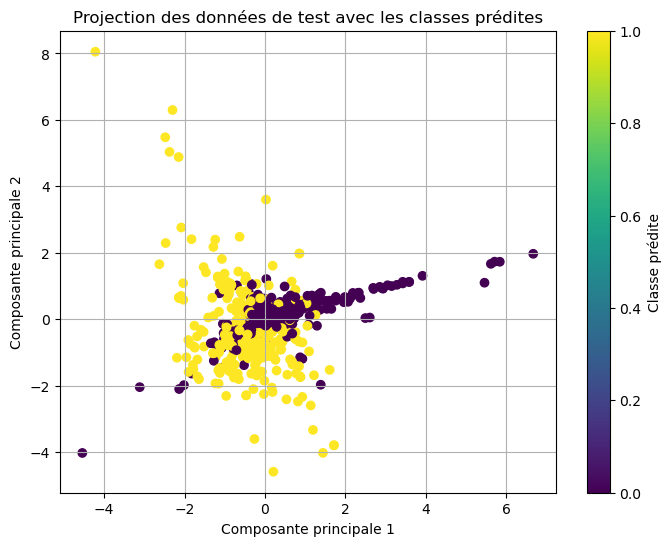

Classe 0 : 61.72%
Classe 1 : 38.28%


In [734]:
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt

# Trouver le meilleur `k` (à définir auparavant)
best_k = 5  # Remplacez par votre méthode de sélection du meilleur k

# Créer et entraîner le modèle KNN
knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X_train_reduced_df, y_train.values.ravel())  # Assurez-vous que y_train est un vecteur 1D

# Prédire sur le jeu de test
test_pred = knn.predict(test_reduced_df)
print(test_pred.shape)


# Plot des données avec les prédictions avec une cle pour dire quelle couleure correspont a quelle classe
plt.figure(figsize=(8, 6))
plt.scatter(test_reduced_df.iloc[:, 0], test_reduced_df.iloc[:, 1], c=test_pred, cmap='viridis')
plt.title("Projection des données de test avec les classes prédites")
plt.xlabel("Composante principale 1")
plt.ylabel("Composante principale 2")
plt.grid()
plt.colorbar(label="Classe prédite")  # Ajouter une barre de couleur pour les classes
plt.show()

#calcul de pourcentage de chaque classe
for i in range(2):
    print(f"Classe {i} : {np.sum(test_pred == i) / len(test_pred) * 100:.2f}%")


In [735]:
#crer une df ou on va ajouter a colone de prediction a la df de test
test_df['label'] = test_pred
test_final = pd.DataFrame(test_df)
print(test_df.shape)

r_df = pandas2ri.py2rpy(test_final)
# Enregistrement dans un fichier .rda
file_path = "test_predictions.rda"
ro.r.assign("test_df", r_df)
ro.r(f"save(test_df, file='{file_path}')")

print(f"Le fichier {file_path} a été enregistré avec succès.")

(862, 58)
Le fichier test_predictions.rda a été enregistré avec succès.
